This is a notebook that calculates neutron capture cross sections at a given T9 in units of millibarns $(mb)$

Here we import the relavent python packages

In [1]:
import sys
!{sys.executable} -m pip install --quiet wnutils

!{sys.executable} -m pip install --quiet astropy

!{sys.executable} -m pip install --quiet networkx

import os, io, requests
from lxml import etree

import wnutils.xml as wx
import numpy as np
from astropy import constants as pc
from astropy import units as u
from matplotlib import pyplot as plt

from collections import defaultdict

import networkx as nx

Now we download an xml that contains the reaction data

In [2]:
my_xml = wx.Xml(io.BytesIO(requests.get('https://osf.io/vqhxr/download').content))

Here we use an xpath to select out only $(n, \gamma)$ reactions

In [3]:
reac = my_xml.get_reaction_data("[reactant = 'n' and count(reactant) = 2  and product = 'gamma' and count(product) = 2]")

Here we choose the temperature, T9, to calculate the cross sections

In [4]:
nuc_xpath = str("[z = 43 and a >= 90 and a <= 100]")

nuclides = {}

nuc = my_xml.get_nuclide_data(nuc_xpath)
nuclides.update(nuc)

In [5]:
t9 = 0.8
T = t9 * 1.e9 * u.K

Now we calculate the thermal velocity

In [6]:
v_t = np.sqrt((2 * pc.k_B.decompose(u.cgs.bases) * T) / pc.m_n.decompose(u.cgs.bases))

In [7]:
sig_dict = {}

filter = {}

In [8]:
for s in reac:
    reaction = reac[s]
    rate = reaction.compute_rate(t9) * u.cm**3 /u.second /u.mol 
    sigma = (rate / (pc.N_A * v_t)).to(u.barn)
        
    usigma = 1000 * sigma / u.barn
    sig_dict[s] = usigma 

We now specify that we only want the $(n,\gamma)$ reactions with the nuclides of interest

In [9]:
for reaction in reac:
    for reactant in reac[reaction].reactants:
        if reactant in nuclides:
            filter[reaction] = [nuclides[reactant]['n']]
            
for reaction in reac:
    for reactant in reac[reaction].reactants:
        if reactant in nuclides:
            filter[reaction].append(reactant)
            
print(filter)

{'n + tc99 -> tc100 + gamma': [56, 'tc99'], 'n + tc95 -> tc96 + gamma': [52, 'tc95'], 'n + tc97 -> tc98 + gamma': [54, 'tc97'], 'n + tc91 -> tc92 + gamma': [48, 'tc91'], 'n + tc100 -> tc101 + gamma': [57, 'tc100'], 'n + tc98 -> tc99 + gamma': [55, 'tc98'], 'n + tc94 -> tc95 + gamma': [51, 'tc94'], 'n + tc93 -> tc94 + gamma': [50, 'tc93'], 'n + tc96 -> tc97 + gamma': [53, 'tc96'], 'n + tc90 -> tc91 + gamma': [47, 'tc90'], 'n + tc92 -> tc93 + gamma': [49, 'tc92']}


In [10]:
for key in list(sig_dict.keys()):
    if key not in filter:
        del sig_dict[key]

Change 2 in {.2f} to change the numver of decimal places shown

In [11]:
print('Cross Sections at T9 of ' + str(t9))

for k,v in sorted(sig_dict.items()):
    x ="{:.2f}".format(v)
    print(str(k)+': ' + str(x) + ' mb')

Cross Sections at T9 of 0.8
n + tc100 -> tc101 + gamma: 682.90 mb
n + tc90 -> tc91 + gamma: 373.49 mb
n + tc91 -> tc92 + gamma: 560.06 mb
n + tc92 -> tc93 + gamma: 767.28 mb
n + tc93 -> tc94 + gamma: 476.53 mb
n + tc94 -> tc95 + gamma: 712.03 mb
n + tc95 -> tc96 + gamma: 558.44 mb
n + tc96 -> tc97 + gamma: 678.43 mb
n + tc97 -> tc98 + gamma: 513.30 mb
n + tc98 -> tc99 + gamma: 834.82 mb
n + tc99 -> tc100 + gamma: 456.89 mb


We now plot $\sigma_n$ vs $n$

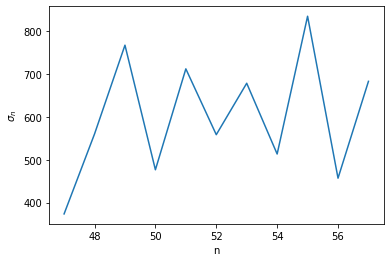

In [12]:
combine = defaultdict(list)

for d in (sig_dict, filter):
    for key, value in d.items():
       combine[key].append(value)
    
sortedcombine = {k: v for k, v in sorted(combine.items(), key=lambda item: item[1][1])}


x = []
y = []

for s in list(sortedcombine.values()):
    x.append(s[1][0])
    y.append(s[0])

#print(sortedcombine)
#print(x)
#print(y)

plt.plot(x, y)
plt.ylabel('$\\sigma_n$')
plt.xlabel('n')
plt.show()

Graph of path chosen.

In [13]:
G = nx.DiGraph()

x = []
y = []
z = []

for s,v in list(sortedcombine.items()):
    x.append(v[1][1])
    y.append(v[0])
    z.append(v[1][1])

z.pop(0)


for i,j,k in zip(x,y,z):
    G.add_node(i)
    G.add_edge(i,k, weight=j)

nx.to_dict_of_dicts(G)

{'tc90': {'tc91': {'weight': <Quantity 373.4922989>}},
 'tc91': {'tc92': {'weight': <Quantity 560.05957545>}},
 'tc92': {'tc93': {'weight': <Quantity 767.28310287>}},
 'tc93': {'tc94': {'weight': <Quantity 476.53037464>}},
 'tc94': {'tc95': {'weight': <Quantity 712.03297147>}},
 'tc95': {'tc96': {'weight': <Quantity 558.4432123>}},
 'tc96': {'tc97': {'weight': <Quantity 678.42813167>}},
 'tc97': {'tc98': {'weight': <Quantity 513.29685288>}},
 'tc98': {'tc99': {'weight': <Quantity 834.81798854>}},
 'tc99': {'tc100': {'weight': <Quantity 456.8880826>}},
 'tc100': {}}

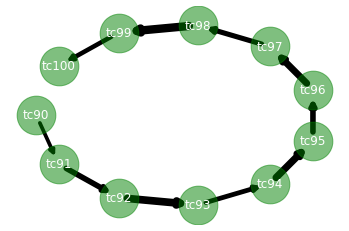

In [14]:
pos = nx.shell_layout(G, scale=1)  

widths = {e: G.edges[e]['weight']/100 for e in G.edges}

nx.draw_networkx_nodes(G,pos,
                       node_size=1500,
                       node_color='green',
                       alpha=0.5)
nx.draw_networkx_edges(G,pos,
                       edgelist = widths.keys(),
                       width=list(widths.values()),
                       edge_color='black',
                       alpha=1)
nx.draw_networkx_labels(G, pos=pos,
                        font_color='white')


plt.box(False)
plt.show()